# Smooth the Marmousi model
We will use this as a starting model for the full waveform inversion demo

In [1]:
using PyPlot, Jets, JetPack, JetPackDSP

## Read in model from binary

In [2]:
nz,nx = 176,851
v = read!("marmousi_vp_20m_176x851.bin", Array{Float32}(undef, nz,nx));

## Smooth model using JetPackDSP convolutional smoother
Note: you may want to `Disable Scrolling for Outputs` by right-click on the next cell, in order to more easily view the help docs.

In [3]:
?JetPackDSP.JopConvolve

```
A = JopConvolve(dom, rng, h [, optional parameters])
```

`A` is an n-dimension convolution (using the filter `h::Array`) operator with domain `dom::JetSpace` and range `rng::JetSpace`, and with the following optional named arguments:

  * `x0` is a tuple defining the origin of the upper-left corner of `h`
  * `dx` is a tuple defining the spacing along each dimension of `h`

# Examples

## 1D, causal

```julia
A = JopConvolve(JetSpace(Float64,128), JetSpace(Float64,128), rand(32))
m = zeros(domain(A))
m[64] = 1.0
d = A*m
```

## 1D, zero-phase

```julia
A = JopConvolve(JetSpace(Float64,128), JetSpace(Float64,128), rand(32), dx=(1.0,), x0=(-16.0,))
m = zeros(domain(A))
m[64] = 1.0
d = A*m
```

## 2D, zero-phase

```julia
A = JopConvolve(JetSpace(Float64,128,128), JetSpace(Float64,128,128), rand(32,32), dx=(1.0,1.0), x0=(-16.0,-16.0))
m = zeros(domain(A))
m[64,64] = 1.0
d = A*m
```

# Notes

  * It is often the case that the domain and range of the convolution operator are the same.  For this use-case, we provide

a convenience method for construction the operator:

```
A = JopConvolve(spc, h [, optional parameters])
```

where `spc::JetSpace` and is used for both `dom` and `rng`.

  * Since smoothing is a common use-case for JopConvolve, we provide a convenience method for creating `A` specific

to n-dimensional smoothing:

```
A = JopConvolve(spc [, optional arguments])
```

where the optional arguments and their default values are:

  * `smoother=:gaussian` choose between `:gaussian`, `:triang` and `:rect`
  * `n=(128,)` choose the size of the smoothing window in each dimension.  If `length(n)=1`, then we assume a square window.
  * `sigma=(0.5,)` for a gaussian window choose the shape of the window.  If `length(sigma)=1`, then we assume the same shape in each dimension.

# 2D Smoothing Example

```julia
P = JopPad(JetSpace(Float64,256,256), -10:256+11, -10:256+11, extend=true)
S = JopConvolve(range(P), smoother=:rect, n=(1,1))
R = JopPad(JetSpace(Float64,256,256), -10:256+11, -10:256+11, extend=false)
m = rand(domain(P))
d = R'∘S∘P*m
```


## Setup the smoothing operator for the Marmousi model

In [4]:
a = 10
b = a+1
P = JopPad(JetSpace(Float64,nz,nx), -b:nz+b, -b:nx+b, extend=true)
S = JopConvolve(range(P), smoother=:rect, n=(a,a))
R = JopPad(JetSpace(Float64,nz,nx), -b:nz+b, -b:nx+b, extend=false)
slowness_sm = R'∘S∘P*(1 ./ v)
vsm = 1 ./(slowness_sm);

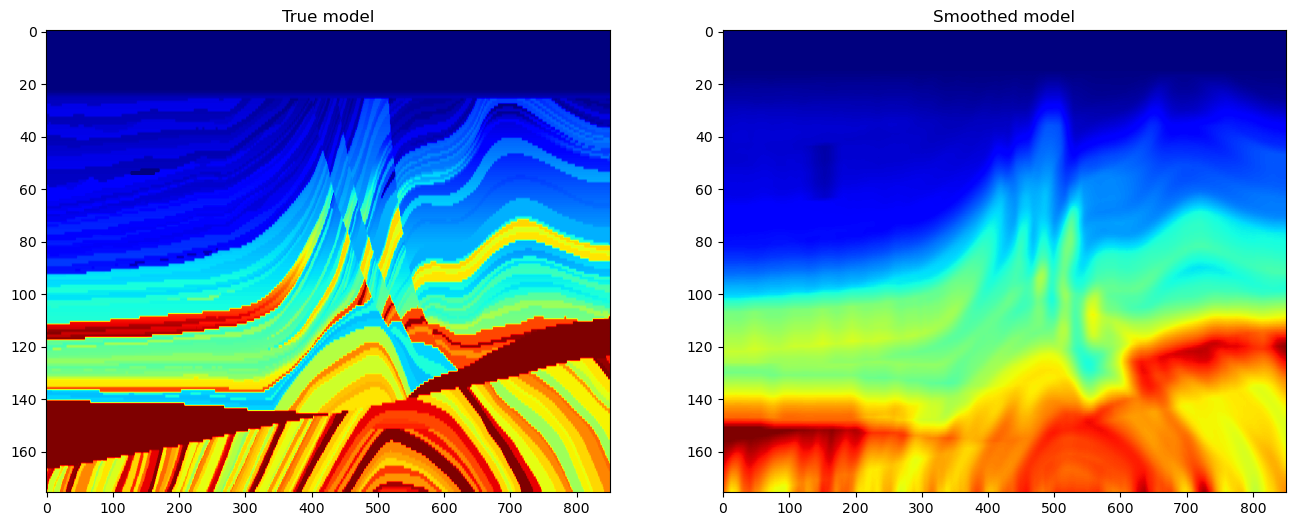

In [5]:
figure(figsize=(16,6))
subplot(121); imshow(v,cmap="jet",aspect="auto"); clim(1500,4500); title("True model");
subplot(122); imshow(vsm,cmap="jet",aspect="auto"); clim(1500,4500); title("Smoothed model");

## Next we find the water layer in the original model and paste it on the smoothed model
Note the elegant Julia construct that assigns to all of the indices in the true model where velocity is 1500 m/s.

In [6]:
vsm[v.==1500.0].=1500.0;

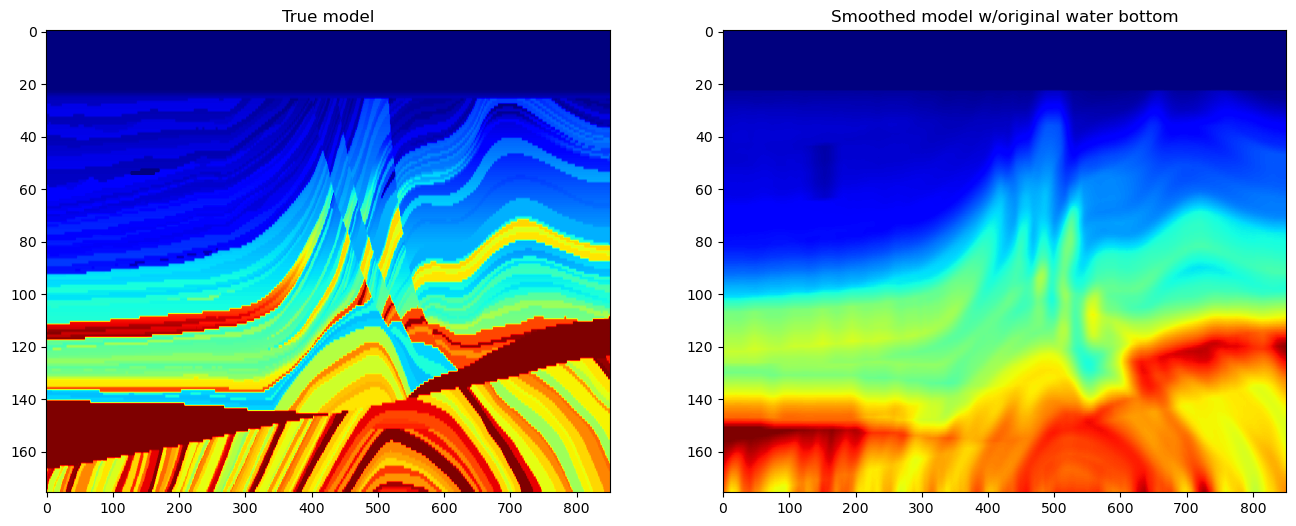

In [7]:
figure(figsize=(16,6))
subplot(121); imshow(v,cmap="jet",aspect="auto"); clim(1500,4500); title("True model");
subplot(122); imshow(vsm,cmap="jet",aspect="auto"); clim(1500,4500); title("Smoothed model w/original water bottom");

## Write out the smoothed model for later

In [8]:
write("marmousi_vp_smooth_20m_176x851.bin",Float32.(vsm));